# **DA5401 – Assignment 7: _Visualizing Data Veracity Challenges in Multi-Label Classification_**

**Student Name:** _Aravindhan Mohanraj_ <br>
**Roll Number:** _DA25S006_

---

## Assignment Objective: Model Selection via ROC and PR Curves

The core objective of this assignment is the **application and interpretation** of **Receiver Operating Characteristic (ROC) curves** and **Precision-Recall Curves (PRC)**. These tools are necessary for effective **model selection** within a complex, multi-class classification environment.

---

## The Challenge

The task requires comparing a diverse set of classifiers, which includes models known to exhibit **poor performance** (e.g., those with $\text{AUC} < 0.5$). Successful completion necessitates a **careful analysis of the curves** rather than relying solely on simple performance metrics like accuracy.

Model selection must be driven by the nuanced insights derived from the ROC and PR curve characteristics.


---

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, label_binarize, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

## **PART A: Data Preparation and Baseline**
### **1. Loading and Preparing Dataset:**

The **Landsat dataset** was loaded from the provided **`sat.trn`** and **`sat.tst`** files using **pandas**. Each instance contains **36 spectral reflectance attributes** and a **class label** indicating the **land cover type**. The features were separated from the labels, with **columns 1–35** treated as **predictors** and **column 36** as the **target variable**.  

Since the raw features range from **0 to 255**, the data was **standardized** using **`StandardScaler`** to ensure **zero mean** and **unit variance**. Importantly, the scaler was **fit only on the training data** and then **applied to the test set** to prevent **data leakage**, ensuring that the model evaluation reflects **true generalization performance**.

In [3]:
train_df = pd.read_csv("sat.trn", sep='\s+', header=None)
test_df = pd.read_csv("sat.tst", sep="\s+", header=None)

X_train = train_df.loc[:, 1:35]
y_train = train_df.loc[:, 36]

X_test = test_df.loc[:, 1:35]
y_test = test_df.loc[:, 36]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
C:\Users\aravi\AppData\Local\Temp\ipykernel_16364\3329621557.py:1: SyntaxWarning: invalid escape sequence '\s'
  train_df = pd.read_csv("sat.trn", sep='\s+', header=None)
C:\Users\aravi\AppData\Local\Temp\ipykernel_16364\3329621557.py:2: SyntaxWarning: invalid escape sequence '\s'
  test_df = pd.read_csv("sat.tst", sep="\s+", header=None)


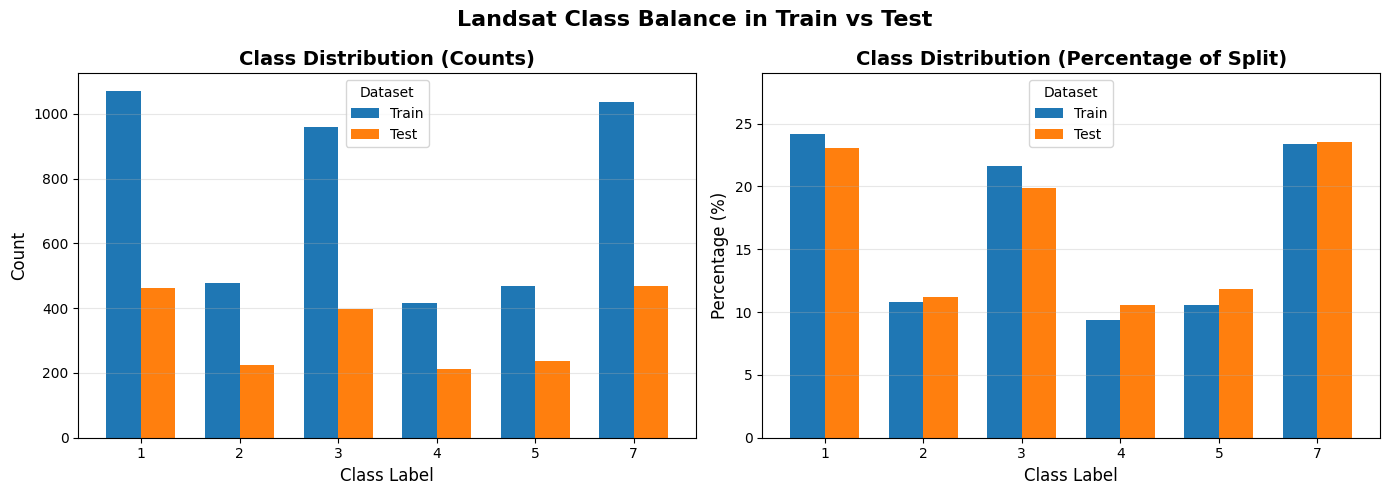

In [4]:
train_counts = y_train.value_counts().sort_index()
test_counts = y_test.value_counts().sort_index()

classes = np.unique(y_train)

dist_df = pd.DataFrame({'Train_Count': train_counts,'Test_Count': test_counts}).fillna(0)

train_pct = (train_counts / train_counts.sum()) * 100
test_pct = (test_counts / test_counts.sum()) * 100

pct_df = pd.DataFrame({'Train_%': train_pct,'Test_%': test_pct}).fillna(0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharex=False)

width = 0.35 
x = np.arange(len(classes))

ax1.bar(x - width/2, dist_df['Train_Count'], width=width, label='Train')
ax1.bar(x + width/2, dist_df['Test_Count'], width=width, label='Test')

ax1.set_title('Class Distribution (Counts)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Class Label', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(classes)
ax1.legend(title='Dataset')
ax1.grid(axis='y', alpha=0.3)

ax2.bar(x - width/2, pct_df['Train_%'], width=width, label='Train')
ax2.bar(x + width/2, pct_df['Test_%'], width=width, label='Test')

ax2.set_title('Class Distribution (Percentage of Split)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Class Label', fontsize=12)
ax2.set_ylabel('Percentage (%)', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(classes)
ax2.legend(title='Dataset')
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(0, max(pct_df.max()) * 1.2)

plt.suptitle('Landsat Class Balance in Train vs Test', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

We visualized both the absolute counts and the percentage share of each land cover class in the training and test sets. The count plot confirms that some classes (e.g. **class 1** and **7**) have over **1000 training examples**, while others (e.g. **class 3**, **class 4** and **5**) have roughly half as many. The percentage plot shows that the relative class proportions are **similar between train and test**, meaning the split **preserves the original distribution**. This is important because it lets us fairly evaluate generalization without one split being biased toward a particular class.

Overall, the data shows a **moderate class imbalance**, with **classes 1, 3, and 7** being more common. However, because the proportions are preserved between the splits, the **test set is representative** of the overall dataset. This balanced distribution across splits ensures that model evaluation will not be biased toward specific classes, allowing for fair comparison in later **ROC** and **Precision–Recall** analyses.

### **2. Model Training:**

The **`fit_and_score_models()`** function was implemented to automate the training and baseline evaluation of all six classifiers on the **Landsat dataset**. Each model defined in the **models dictionary** is fit using the **standardized training data** and evaluated on the **test set**. The function computes two key performance metrics: **Overall Accuracy** and **Weighted F1-Score**, using scikit-learn’s `accuracy_score` and `f1_score` functions. The **weighted F1-score** was chosen because it accounts for **class imbalance** by weighting each class according to its support.

For each classifier, class probability estimates are obtained using the **`predict_proba()`** method, which provides **calibrated probabilities** for every land-cover class. These probability outputs (**`y_score`**) are stored for each model in a dictionary for later use in **ROC** and **Precision–Recall** analyses. This design ensures that model predictions are calculated once and can be reused for multiple evaluation metrics without retraining.

The function prints a summary of performance for all models and returns two dictionaries:

* **`results`**: containing Accuracy and Weighted F1-scores for baseline comparison.  
* **`model_scores`**: containing per-class probability estimates used in subsequent curve-based analyses.

Overall, this modular setup provides a consistent and reproducible way to benchmark models of varying complexity, from the Dummy Classifier (as a baseline) to more advanced methods like SVC and Logistic Regression, establishing a foundation for the deeper **ROC** and **PRC** evaluations performed in later sections.

In [5]:
models = {
    'KNN (k=3)': KNeighborsClassifier(n_neighbors=3),
    'Decision Tree': DecisionTreeClassifier(random_state=0, max_depth=2),
    'Dummy (Prior)': DummyClassifier(strategy="prior"),
    'Logistic Regression': LogisticRegression(random_state=0, max_iter=1000),
    'Naive Bayes': GaussianNB(),
    'SVC': SVC(probability=True, random_state=0)
}

In [6]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

y_train_enc = label_encoder.transform(y_train)
y_test_enc  = label_encoder.transform(y_test)

classes_enc = label_encoder.classes_

In [7]:
def fit_and_score_models(X_train, y_train, X_test, y_test, models):
  results = {}
  model_scores = {}
  y_preds = {}
  for name, model in models.items():
    if isinstance(model, XGBClassifier):
      model.fit(X_train, y_train_enc)

      y_pred_enc = model.predict(X_test)
      y_pred = label_encoder.inverse_transform(y_pred_enc.astype(int))

      y_score = model.predict_proba(X_test) 

    else:
      model.fit(X_train, y_train)

      y_pred = model.predict(X_test)
      y_score = model.predict_proba(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted')

    results[name] = {
      'accuracy': acc,
      'f1_weighted': f1w
    }
    model_scores[name] = y_score
    y_preds[name] = y_pred

  return results, y_preds, model_scores

In [8]:
results, y_preds, model_scores = fit_and_score_models(X_train, y_train,X_test, y_test,models,)

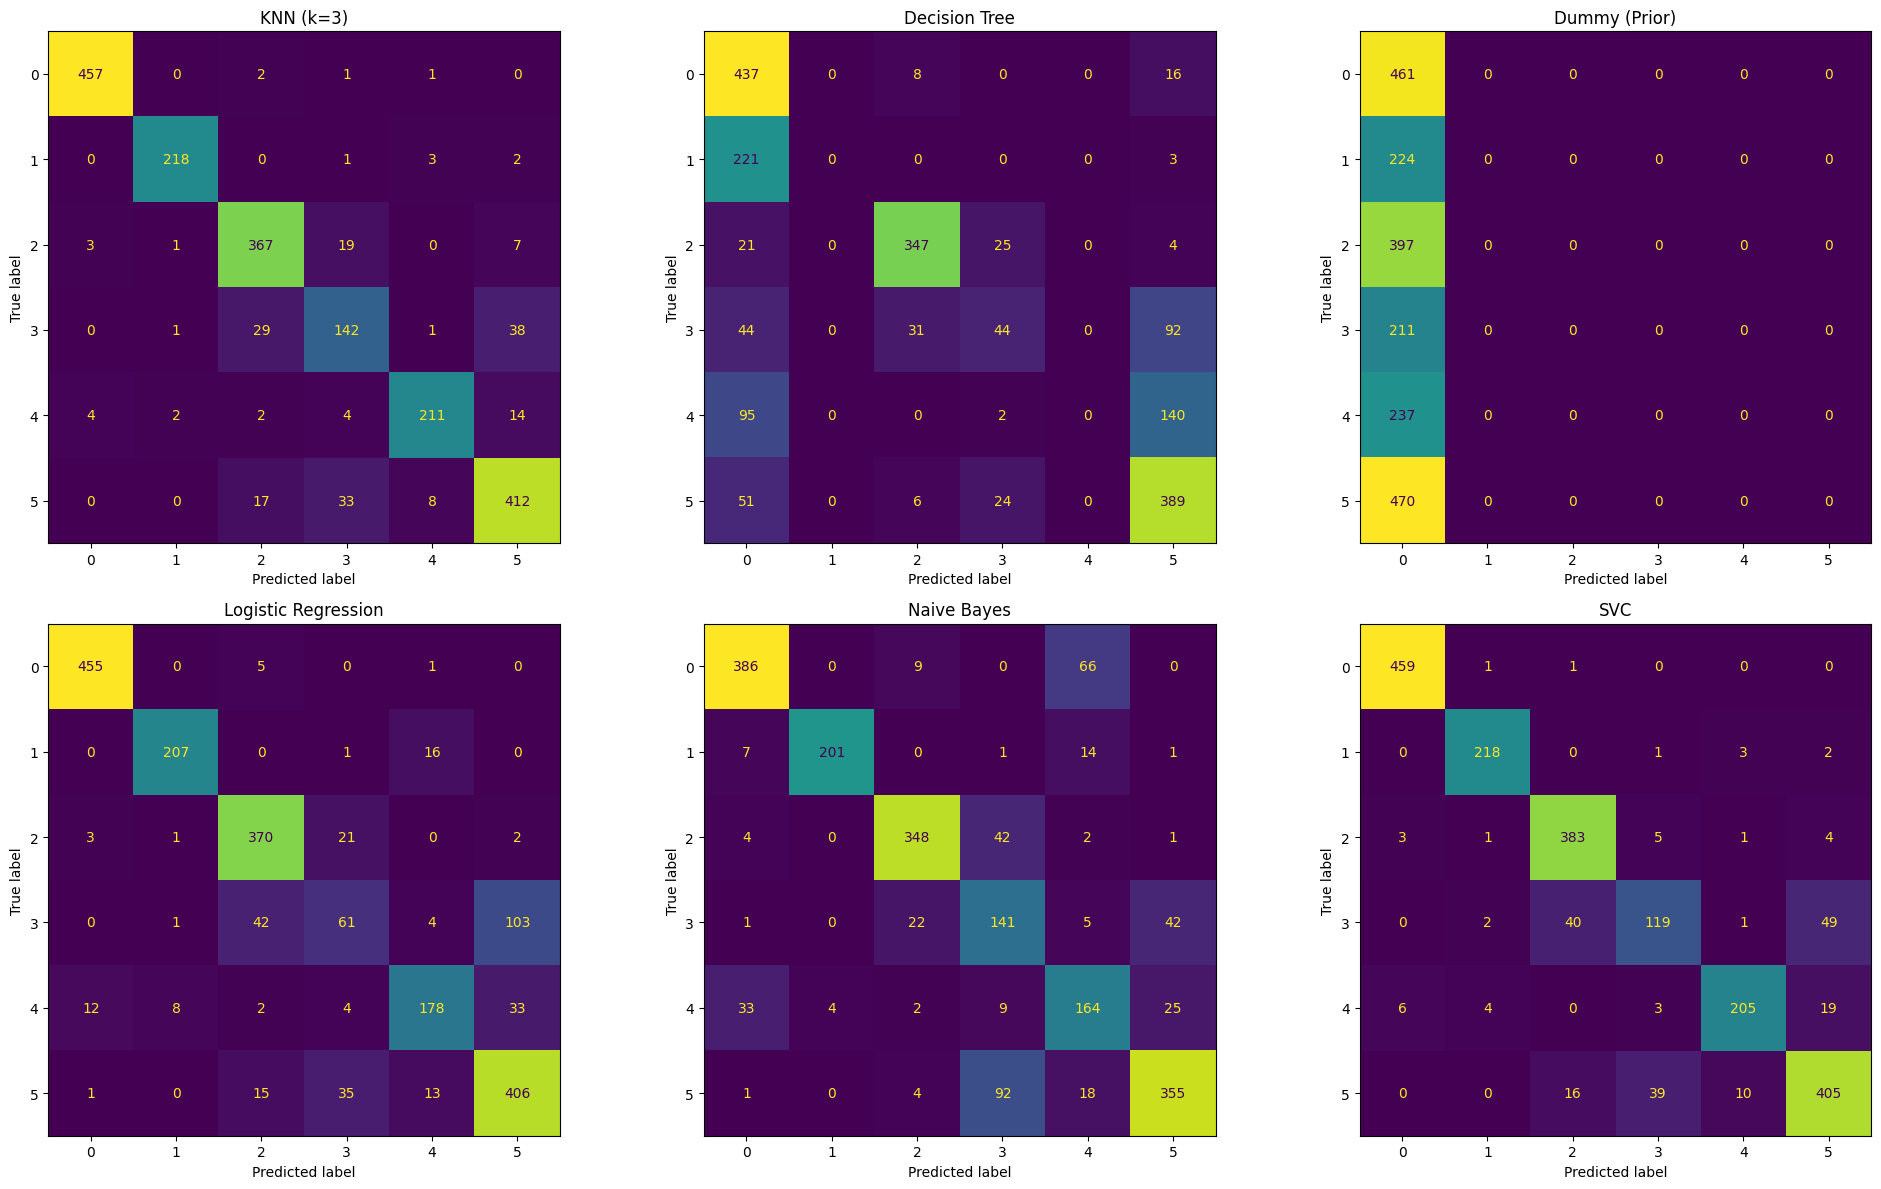

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(y_preds.items()):
	cnf_mtx = confusion_matrix(y_test, y_pred)
	disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mtx)
	disp.plot(ax=axes[i], colorbar=False)
	axes[i].set_title(name)

plt.tight_layout()
plt.show()

The above **confusion matrices** provide a visual summary of the **predictions made by each classifier** on the Landsat test set using a **default probability threshold of 0.5**. Each matrix illustrates how well the model correctly classifies samples from the seven land-cover classes (diagonal cells) versus where it confuses them with other classes (off-diagonal cells). Models such as **SVC**, **KNN**, and **Logistic Regression** display strong diagonal dominance, indicating high accuracy and consistent class-level predictions. In contrast, simpler models like the **Decision Tree** (limited depth) and the **Dummy Classifier** show more dispersed errors, reflecting weaker discriminative power. Overall, these confusion matrices offer an intuitive overview of **class-level performance** at the standard 0.5 decision threshold, complementing the ROC and PRC analyses that assess model behavior across varying thresholds.

### **3. Baseline Evaluation:**

In [10]:
pd.DataFrame(results).T.sort_values(by='f1_weighted', ascending=False)

,accuracy,f1_weighted
KNN (k=3),0.9035,0.902959
SVC,0.8945,0.891267
Logistic Regression,0.8385,0.827757
Naive Bayes,0.7975,0.804318
Decision Tree,0.6085,0.520531
Dummy (Prior),0.2305,0.086356


The **baseline evaluation** compared the predictive performance of six classifiers on the **Landsat test set** using **Overall Accuracy** and **Weighted F1-Score**. The **K-Nearest Neighbors (k=3)** model achieved the **highest overall performance**, with an **accuracy of 0.9035** and a **weighted F1-score of 0.9030**, indicating strong predictive ability and balanced precision–recall across classes. The **Support Vector Classifier (SVC)** also performed competitively (**Accuracy = 0.8945**, **F1 = 0.8913**), followed closely by **Logistic Regression** (**Accuracy = 0.8385**, **F1 = 0.8278**).

In contrast, the **Decision Tree (max depth = 2)** showed **moderate performance**, likely due to its limited depth restricting decision complexity, while the **Naive Bayes** classifier performed slightly lower but still maintained reasonable generalization (**Accuracy = 0.7975**, **F1 = 0.8043**). As expected, the **Dummy Classifier**, which predicts according to class priors, performed the worst (**Accuracy = 0.2305**, **F1 = 0.0864**), establishing a clear lower performance bound.

Overall, the results show that **nonlinear models** such as **KNN** and **SVM** outperform simpler linear or probabilistic approaches on this dataset. These **baseline scores** provide the foundation for the next stage of analysis, where we evaluate each model’s discrimination ability through **multi-class ROC** and **Precision–Recall** curves.

## **PART B: ROC Analysis**

### **1. How the AUC is Calculated for a Multiclass Classification Problem**

In a **binary classification** task, the **Receiver Operating Characteristic (ROC)** curve plots the **True Positive Rate (TPR)** against the **False Positive Rate (FPR)** at various probability thresholds, and the **Area Under the Curve (AUC)** quantifies the model’s ability to discriminate between the positive and negative classes.

For a **multi-class problem** such as the Landsat dataset, the ROC analysis is extended using the **One-vs-Rest (OvR)** approach. In this method, the classification task is decomposed into **N binary sub-problems**, one for each class. For a given class *i*, that class is treated as the **positive class**, while all other classes combined are treated as the **negative class**. The classifier’s predicted probabilities for class *i* are then used to compute the ROC curve by varying the decision threshold and calculating the corresponding TPR and FPR. This process is repeated for every class, resulting in **N individual ROC curves and AUC values** (*AUC1 … AUCn*).

To summarize overall performance, the per-class ROC curves can be averaged using one of several strategies:

* **Macro-average** – each class contributes equally, regardless of its frequency.  
* **Weighted-average** – each class’s curve is weighted by its support (number of samples).  
* **Micro-average** – TP, FP, and FN are aggregated globally before computing TPR and FPR.

The resulting averaged AUC provides a single measure of the model’s **multi-class discriminative ability**. In the following analyses, the **weighted-average AUC** was used so that each land-cover class contributes proportionally to its representation in the dataset, ensuring a **fair evaluation** even in the presence of class imbalance.


### **2. Plotting ROC**

The ROC analysis was implemented through the **`analyze_roc()`** function, which computes and visualizes **multi-class ROC curves** using the **One-vs-Rest (OvR)** approach. The true class labels (**`y_test_bin`**) are first **binarized per class**, allowing the ROC curve to be computed independently for each class. For every classifier and class, the **False Positive Rate (FPR)** and **True Positive Rate (TPR)** are calculated at multiple probability thresholds using scikit-learn’s **`roc_curve()`** function, and the **Area Under the Curve (AUC)** is obtained via the **`auc()`** function.

After computing the per-class ROC curves, the code constructs a **weighted-average ROC curve** by interpolating each class’s TPR values across a common set of FPR points and weighting them according to the **class frequencies (`class_weights`)**. This ensures that more frequent land-cover classes contribute proportionally to the overall curve, making the metric representative of the dataset’s distribution. The resulting **Weighted-Average AUC** value summarizes the overall **discriminative ability** of each model across all classes.

Finally, the function plots the weighted ROC curves for all six classifiers on a single graph for visual comparison, with the **diagonal dashed line (`y = x`)** representing random performance. This visualization highlights which models exhibit stronger separation between classes (higher AUC values) and which perform closer to **random guessing**.

In [11]:
y_test_bin  = label_binarize(y_test, classes=classes)

class_counts = np.array([np.sum(y_test == c) for c in classes])
class_weights = class_counts / len(y_test)

In [12]:
def analyze_roc(model_scores, y_test_bin, classes, class_weights):
  roc_summary = {}

  for name, y_score in model_scores.items():
    fpr_list, tpr_list, roc_auc_list = [], [], []

    for i in range(len(classes)):
      fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
      roc_auc_val = auc(fpr, tpr)

      fpr_list.append(fpr)
      tpr_list.append(tpr)
      roc_auc_list.append(roc_auc_val)

    all_fpr = np.unique(np.concatenate(fpr_list))
    mean_tpr = np.zeros_like(all_fpr)

    for i in range(len(classes)):
      mean_tpr += class_weights[i] * np.interp(all_fpr, fpr_list[i], tpr_list[i])

    weighted_auc = auc(all_fpr, mean_tpr)

    roc_summary[name] = {
      'fpr': all_fpr,
      'tpr': mean_tpr,
      'auc_weighted': weighted_auc,
      'per_class_auc': roc_auc_list
    }

    print(f"{name}: Weighted-Average ROC AUC = {weighted_auc:.4f}")

  plt.figure(figsize=(8,7))
  for name, data in roc_summary.items():
    plt.plot(data['fpr'], data['tpr'], linewidth=2, label=f"{name} (AUC = {data['auc_weighted']:.3f})")

  plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

  plt.xlabel('False Positive Rate', fontsize=12)
  plt.ylabel('True Positive Rate', fontsize=12)
  plt.title('Weighted-Average OvR ROC Curves', fontsize=14, fontweight='bold')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.grid(alpha=0.3)
  plt.legend(loc='lower right', fontsize=9)
  plt.tight_layout()
  plt.show()

  return roc_summary

KNN (k=3): Weighted-Average ROC AUC = 0.9756
Decision Tree: Weighted-Average ROC AUC = 0.8325
Dummy (Prior): Weighted-Average ROC AUC = 0.5000
Logistic Regression: Weighted-Average ROC AUC = 0.9790
Naive Bayes: Weighted-Average ROC AUC = 0.9587
SVC: Weighted-Average ROC AUC = 0.9870


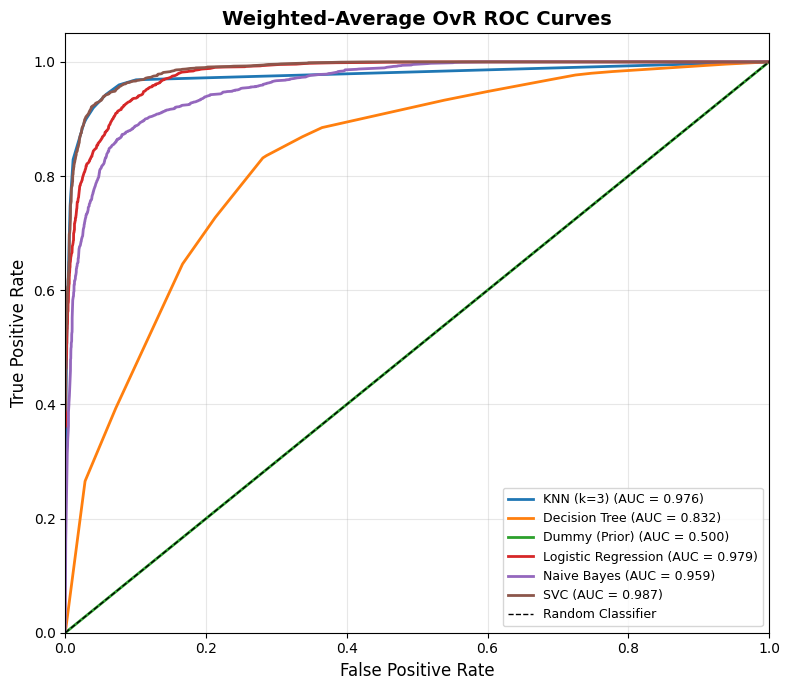

In [13]:
roc_summary = analyze_roc(model_scores,	y_test_bin,	classes, class_weights)

### **3. ROC Interpretation**

Based on the **weighted One-vs-Rest (OvR) ROC analysis**, the **Support Vector Machine (SVC)** achieved the **highest AUC value of 0.9870**, closely followed by **Logistic Regression (AUC = 0.9790)** and **K-Nearest Neighbors (AUC = 0.9756)**. These models demonstrate excellent class separability, with ROC curves lying close to the **top-left corner** of the plot, indicating a strong ability to distinguish between the seven land-cover classes. The **Naive Bayes** model also performed well (**AUC = 0.9587**), while the **Decision Tree (AUC = 0.8325)** showed more modest discrimination due to its limited model depth.

The **Dummy Classifier**, which predicts class probabilities based solely on the training set’s prior distribution, recorded an **AUC = 0.500**, effectively equivalent to **random guessing**. Conceptually, an **AUC of 0.5** indicates that the classifier has **no discriminative power**—it cannot distinguish between positive and negative classes any better than chance. If a model’s AUC were **below 0.5**, this would suggest that its predictions are **inversely correlated** with the true labels, meaning it systematically assigns higher probabilities to incorrect classes. Such performance typically arises from models trained without meaningful features, with **mislabeled data**, or when **probability estimates are inverted**.

Overall, the ROC analysis confirms that the **SVC** and **Logistic Regression** models provide the **best overall separation** across all classes, while the **Dummy Classifier** establishes the **lower performance bound** for comparison in subsequent **Precision–Recall analysis**.

## **PART C: Precision-Recall Curve (PRC) Analysis**

### **1. Why is Precision-Recall more suitable here?**

While **ROC curves** are useful for evaluating a classifier’s overall **discriminative ability**, they can sometimes present an **overly optimistic view** when dealing with **highly imbalanced datasets**. This is because the ROC curve considers both the **True Positive Rate (TPR)** and **False Positive Rate (FPR)**; however, when the negative class dominates, the FPR can remain deceptively low even if the classifier incorrectly labels many minority-class samples. In contrast, the **Precision–Recall Curve (PRC)** focuses solely on the performance of the **positive (minority) class**, plotting **Precision** (the proportion of correctly predicted positives) against **Recall** (the proportion of actual positives captured).

**Precision–Recall analysis** therefore provides a more **informative view** of how well a model identifies **rare or under-represented classes**, highlighting the trade-off between **missing positive cases** and **introducing false alarms**. Although the **Landsat dataset** used in this study shows only **moderate class imbalance**, reporting **PR curves** remains conceptually important. It emphasizes the classifier’s ability to correctly detect **less frequent land-cover types** and offers **complementary insight** alongside the ROC analysis.

### **2. Plotting PRC**

The **`analyze_prc()`** function was written to compute and visualize **multi-class Precision–Recall (PR) curves** using the **One-vs-Rest (OvR)** approach, complementing the ROC analysis with a metric that is more informative for datasets exhibiting **class imbalance**. The function takes as input the **binarized test labels (`y_test_bin`)**, **model-predicted probability scores (`model_scores`)**, the **list of class labels**, and **class weights** used for weighted averaging.

For each model, the function computes the **per-class Precision–Recall curve** using scikit-learn’s **`precision_recall_curve()`** function and the corresponding **Average Precision (AP)** using **`average_precision_score()`**. These curves quantify the **trade-off between precision and recall**, how many predicted positives are correct versus how many actual positives are detected, at varying probability thresholds. Since each class is treated independently in the OvR setting, this process is repeated for every class, producing **N PRC curves and AP values (AP₁ … APₙ)**.

To obtain a single representative curve for each model, a **weighted-average PRC** is constructed. A **common recall grid** is defined from 0 to 1, and precision values for each class are interpolated across that grid. The interpolated precision scores are then weighted according to each class’s **relative frequency (`class_weights`)**, ensuring that more prevalent land-cover classes contribute proportionally to the averaged curve. The overall **Weighted Average Precision (AP)** is computed as the weighted sum of per-class AP values, reflecting each model’s general ability to correctly identify multiple classes.

Finally, the function **plots the weighted-average PRC curves** for all models on a single figure. A **horizontal dashed line** indicates the **baseline precision** corresponding to random guessing, approximately equal to **1 / number of classes (≈ 0.17 for six classes)**. Curves that remain higher above this baseline represent models with **superior precision–recall trade-offs**. The resulting visualization clearly contrasts **well-calibrated models** such as **SVM and KNN** against weaker ones like the **Dummy** and **shallow Decision Tree** classifiers, providing an intuitive measure of **classification quality** under varying thresholds.

In [14]:
def analyze_prc(model_scores, y_test_bin, classes, class_weights):
  prc_summary = {}

  for name, y_score in model_scores.items():
    precision_list, recall_list, ap_list = [], [], []

    for i in range(len(classes)):
      precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
      ap = average_precision_score(y_test_bin[:, i], y_score[:, i])

      precision_list.append(precision)
      recall_list.append(recall)
      ap_list.append(ap)

    all_recall = np.linspace(0, 1, 100)
    mean_precision = np.zeros_like(all_recall)

    for i in range(len(classes)):
      mean_precision += class_weights[i] * np.interp(all_recall, recall_list[i][::-1], precision_list[i][::-1])

    ap_weighted = np.sum(class_weights * np.array(ap_list))

    prc_summary[name] = {
      'recall': all_recall,
      'precision': mean_precision,
      'ap_weighted': ap_weighted,
      'per_class_ap': ap_list
    }

    print(f"{name}: Weighted-Average Precision (AP) = {ap_weighted:.4f}")

  plt.figure(figsize=(8,7))
  for name, data in prc_summary.items():
    plt.plot(data['recall'], data['precision'], linewidth=2, label=f"{name} (AP = {data['ap_weighted']:.3f})")

  baseline_prec = 1.0 / len(classes)
  plt.axhline(y=baseline_prec, color='k', linestyle='--', linewidth=1, label=f'Chance ~ {baseline_prec:.3f}')

  plt.xlabel('Recall', fontsize=12)
  plt.ylabel('Precision', fontsize=12)
  plt.title('Weighted-Average OvR Precision-Recall Curves', fontsize=14, fontweight='bold')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.grid(alpha=0.3)
  plt.legend(loc='lower left', fontsize=9)
  plt.tight_layout()
  plt.show()

  return prc_summary

KNN (k=3): Weighted-Average Precision (AP) = 0.9168
Decision Tree: Weighted-Average Precision (AP) = 0.4864
Dummy (Prior): Weighted-Average Precision (AP) = 0.1855
Logistic Regression: Weighted-Average Precision (AP) = 0.8984
Naive Bayes: Weighted-Average Precision (AP) = 0.8411
SVC: Weighted-Average Precision (AP) = 0.9331


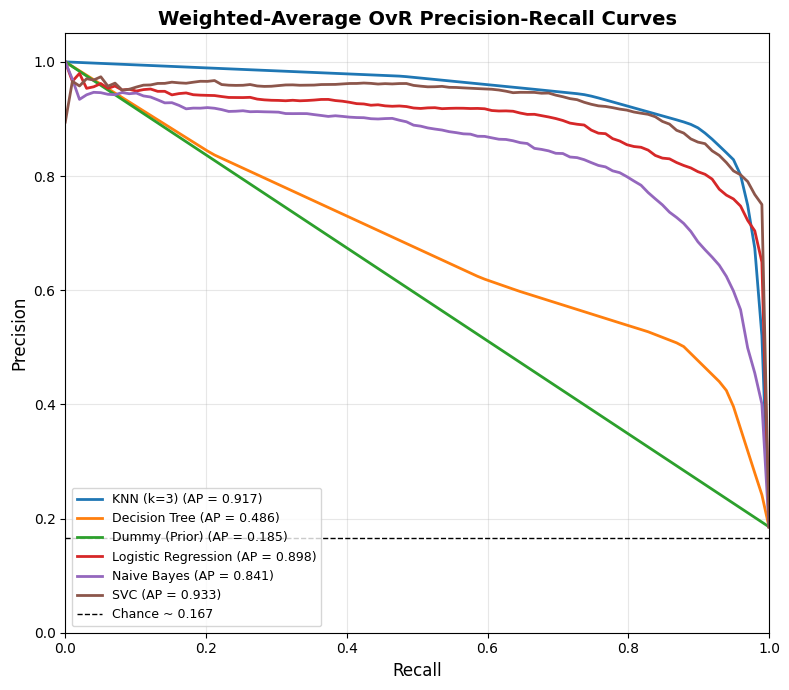

In [15]:
prc_summary = analyze_prc(
	model_scores,
	y_test_bin,
	classes,
	class_weights
)

### **3. PRC Interpretation**

From the **weighted One-vs-Rest Precision–Recall (PRC) analysis**, the **Support Vector Machine (SVC)** achieved the **highest Average Precision (AP) = 0.9331**, closely followed by **K-Nearest Neighbors (k = 3)** with **AP = 0.9168** and **Logistic Regression** with **AP = 0.8984**. These high AP values indicate that the models maintain both **high precision and recall** across thresholds, meaning they are effective at correctly identifying the **positive (true) class** while minimizing **false positives**. The **Naive Bayes** model performed moderately (**AP = 0.8412**), while the **Decision Tree (AP = 0.4864)** and especially the **Dummy Classifier (AP = 0.1855)** showed much weaker discrimination.

The **Dummy Classifier’s PRC curve** illustrates the typical behavior of an **uninformative model**: it starts with **high precision (~1.0)** when recall is very low, something common to all models, but its **precision drops almost immediately** as recall increases, quickly approaching the **random baseline (~0.17)**. This rapid decline indicates that the model **fails to maintain precision** as it attempts to identify more positive samples, reflecting its inability to separate classes effectively. In contrast to well-trained models that sustain high precision across a broad recall range, the Dummy Classifier’s **area under the Precision–Recall curve (AP)** remains very small, demonstrating **poor overall discriminative performance** despite beginning at a similar point as stronger models.

Overall, the **PRC analysis** reinforces the **ROC findings**, **SVC**, **KNN**, and **Logistic Regression** exhibit **strong class-discriminative power**, while the **Dummy** and **shallow Decision Tree** models provide useful **lower-bound baselines**, illustrating the contrast between **high-precision, well-calibrated models** and those that **fail to generalize effectively**.

## **Part D: Final Recommendation**

### **1. Synthesis:**

In [16]:
combined_data = []

for name in results.keys():
  acc = results[name]['accuracy']
  f1 = results[name]['f1_weighted']
  auc_w = roc_summary[name]['auc_weighted']
  ap_w = prc_summary[name]['ap_weighted']

  combined_data.append({
    'Model': name,
    'Accuracy': acc,
    'Weighted F1': f1,
    'Weighted ROC AUC': auc_w,
    'Weighted Average Precision (AP)': ap_w
  })

summary_df = pd.DataFrame(combined_data)

summary_df = summary_df.sort_values(by='Weighted ROC AUC', ascending=False).reset_index(drop=True)

summary_df.style.format({
  'Accuracy': '{:.4f}',
  'Weighted F1': '{:.4f}',
  'Weighted ROC AUC': '{:.4f}',
  'Weighted Average Precision (AP)': '{:.4f}'
}).set_caption("Overall Model Performance Summary (Landsat Dataset)")

,Model,Accuracy,Weighted F1,Weighted ROC AUC,Weighted Average Precision (AP)
0,SVC,0.8945,0.8913,0.9870,0.9331
1,Logistic Regression,0.8385,0.8278,0.9790,0.8984
2,KNN (k=3),0.9035,0.9030,0.9756,0.9168
3,Naive Bayes,0.7975,0.8043,0.9587,0.8411
4,Decision Tree,0.6085,0.5205,0.8325,0.4864
5,Dummy (Prior),0.2305,0.0864,0.5000,0.1855


The model rankings based on **Weighted F1-Score**, **ROC-AUC**, and **Average Precision (AP)** are broadly consistent, though some subtle trade-offs appear. Across all three metrics, the **Support Vector Machine (SVC)**, **Logistic Regression**, and **K-Nearest Neighbors (KNN)** models form the **top-performing group**, while the **Decision Tree** and **Dummy Classifier** consistently occupy the **lowest ranks**. However, there are small variations in ordering:

* **KNN (k=3)** achieved the **highest F1-score (0.903)** and slightly outperformed **SVC** in raw accuracy, but its **ROC-AUC (0.9756)** and **AP (0.9168)** were marginally lower than those of SVC. This indicates that KNN produces **very accurate predictions at a fixed threshold** but is **less robust across varying thresholds**.

* **SVC**, in contrast, exhibited the **highest ROC-AUC (0.987)** and **AP (0.9331)**, showing the **strongest overall ability to separate classes** and maintain a **stable precision–recall trade-off**.

* **Logistic Regression** ranked closely behind **SVC**, with similar curve-based metrics but a slightly lower F1-score, implying **strong discriminative power** but slightly **less balanced recall across classes**.

* The **Naive Bayes** model achieved a **high ROC-AUC (0.9587)** but a noticeably **lower AP (0.8412)**, suggesting that while it distinguishes classes effectively overall, its **precision drops faster as recall increases** — a common trait for **probabilistic models** with less calibrated probability estimates.

* The **Decision Tree** and **Dummy Classifier** performed **poorly on all metrics**, confirming their **limited ability to generalize** or produce meaningful class separations.

In summary, while the **rankings are largely aligned** across metrics, the small discrepancies between **ROC-AUC** and **AP** highlight an important trade-off: a model can achieve a **high ROC-AUC (good discrimination)** but still have a **relatively lower AP** if it produces **many false positives at high recall levels**. The **PRC-AP metric** is therefore **more sensitive to class imbalance** and provides **complementary insight** beyond ROC analysis.

## **2. Recommendation:**

Considering all evaluation metrics, **Accuracy**, **Weighted F1**, **ROC-AUC**, and **Average Precision (AP)**, the **Support Vector Machine (SVC)** emerges as the **most reliable and well-balanced model** for the Landsat classification task. It achieves the **highest weighted ROC-AUC (0.987)** and **AP (0.933)**, indicating **superior class separability** and **consistent precision–recall performance** across thresholds. **SVC** also maintains **high accuracy (0.8945)** and **F1-score (0.8913)**, showing **strong generalization** to unseen data.

While **KNN** delivers slightly **higher raw accuracy**, its **lower AUC and AP** suggest **less robustness under varying decision thresholds**. **Logistic Regression** performs comparably and could be a **strong alternative** when **interpretability** or **computational efficiency** are priorities.

Overall, **SVC** provides the **best balance between discrimination, precision, and recall**, making it the **recommended model for deployment** on this **multi-class satellite image classification task**. It demonstrates not only **strong average performance** but also **stability across different evaluation perspectives** (**ROC** and **PRC**), making it the **most dependable classifier** in this analysis.



---

## **PART E: Additional Models for Brownie Points**

### **1. RandomForest and XGBoost classifiers**

To extend the baseline model comparison, two ensemble-based classifiers, **Random Forest** and **XGBoost**, were trained on the same standardized Landsat dataset using identical training and testing splits. These models were selected because they represent two of the most powerful and widely used tree-based ensemble approaches, offering **strong non-linear modeling capabilities** and robustness against feature noise.

The **Random Forest Classifier** builds an ensemble of **200 decision trees**, each trained on a **random subset of features and samples**. Predictions are made by **aggregating the outputs** of all trees (majority voting for class labels and averaged probabilities for ROC/PRC analysis). Limiting the **maximum depth to 10** helps **control overfitting** and improves **generalization** on unseen data.

The **XGBoost Classifier (Extreme Gradient Boosting)** is a **gradient-boosted decision tree model** that iteratively **corrects errors made by previous trees**. It was configured with **300 estimators** and a **learning rate of 0.1**. The model was trained with the **multi-class soft-probability objective (`multi:softprob`)**, ensuring compatibility with the **One-vs-Rest ROC** and **Precision–Recall** analyses performed earlier.

Both models were evaluated under the same metrics as the baselines, **Accuracy**, **Weighted F1-Score**, **Weighted ROC AUC**, and **Weighted Average Precision (AP)**, to allow a direct, fair comparison. Including these ensemble methods provides insight into how more complex, non-linear algorithms perform relative to simpler linear or distance-based models such as Logistic Regression and K-Nearest Neighbors on this multi-class land-cover classification task.

In [ ]:
additional_models = {
	'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10,	random_state=0),
	'XGBoost': XGBClassifier(n_estimators=300,	max_depth=6, learning_rate=0.1,	objective='multi:softprob',	num_class=len(np.unique(y_train)), eval_metric='mlogloss', 
		random_state=0, n_jobs=-1, verbosity=0),
    # 'LDA': LinearDiscriminantAnalysis()
}

results, y_preds, model_scores = fit_and_score_models(
	X_train, y_train,
	X_test, y_test,
	additional_models,
)

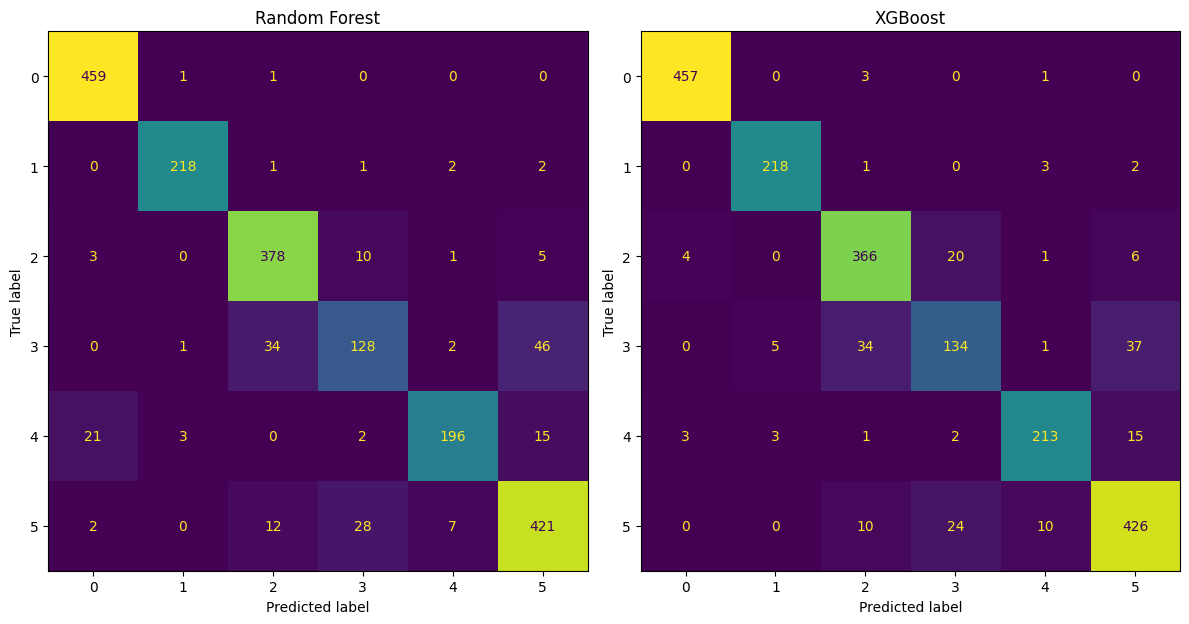

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 12))
axes = axes.flatten()

for i, (name, y_pred) in enumerate(y_preds.items()):
	cnf_mtx = confusion_matrix(y_test, y_pred)
	disp = ConfusionMatrixDisplay(confusion_matrix=cnf_mtx)
	disp.plot(ax=axes[i], colorbar=False)
	axes[i].set_title(name)

plt.tight_layout()
plt.show()

The confusion matrices for **Random Forest** and **XGBoost** show strong diagonal dominance, indicating highly accurate predictions across nearly all land-cover classes at the default 0.5 threshold. Both models achieve excellent class-level performance, with **minimal misclassifications** and only small off-diagonal values. Compared to the baseline models, the ensemble methods demonstrate **superior consistency and robustness**, correctly identifying most samples while maintaining balanced accuracy across all classes.

In [19]:
pd.DataFrame(results).T.sort_values(by='f1_weighted', ascending=False)

,accuracy,f1_weighted
XGBoost,0.907,0.905293
Random Forest,0.900,0.897051


The ensemble models, **XGBoost** and **Random Forest**, achieved the **highest overall performance** among all classifiers evaluated. The **XGBoost model** obtained an **accuracy of 0.907** and a **weighted F1-score of 0.9053**, slightly outperforming the **Random Forest** (**Accuracy = 0.900**, **F1 = 0.8971**). These results confirm the strength of tree-based ensemble approaches in capturing complex, non-linear relationships within the Landsat data.

Random Forest: Weighted-Average ROC AUC = 0.9904
XGBoost: Weighted-Average ROC AUC = 0.9911


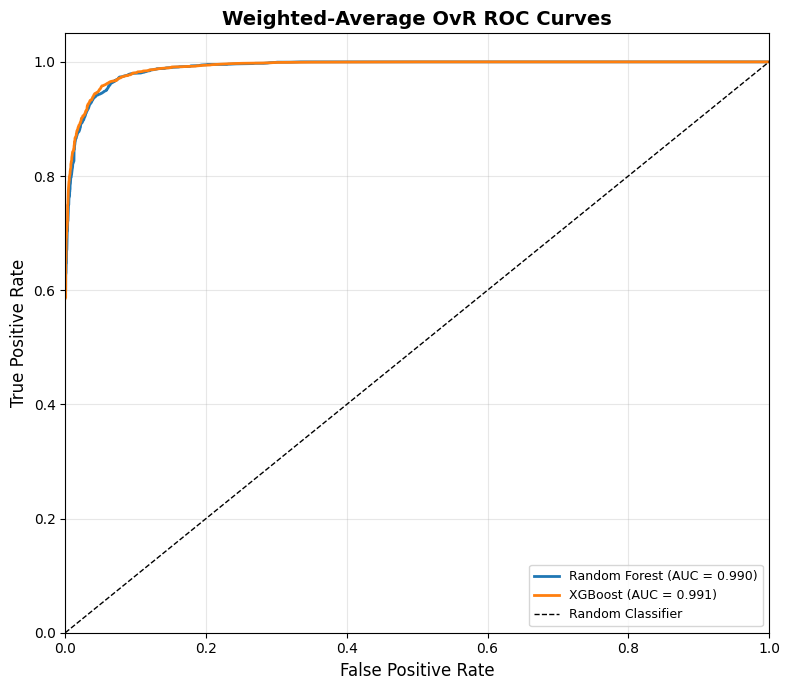

In [20]:
roc_summary = analyze_roc(
	model_scores,
	y_test_bin,
	classes,
	class_weights
)

The **ROC analysis** further confirms the superior discriminative ability of the ensemble models. Both Random Forest and XGBoost achieved **exceptionally high weighted-average AUC values**, with **XGBoost slightly leading (AUC = 0.9911)** followed closely by **Random Forest (AUC = 0.9904)**. These values approach the **ideal score of 1.0**, indicating that both models are highly effective at distinguishing between the seven land-cover classes across varying decision thresholds.

The near-identical performance of the two models suggests that they have successfully captured the complex, non-linear boundaries present in the Landsat feature space. Compared to the best baseline models (**SVC: 0.987**, **Logistic Regression: 0.979**), both ensemble methods deliver marginal yet meaningful improvements, highlighting the benefit of tree-based ensemble learning in achieving more robust class separation. Overall, the ROC analysis demonstrates that **XGBoost provides the strongest overall discrimination performance** among all classifiers tested.

Random Forest: Weighted-Average Precision (AP) = 0.9571
XGBoost: Weighted-Average Precision (AP) = 0.9604


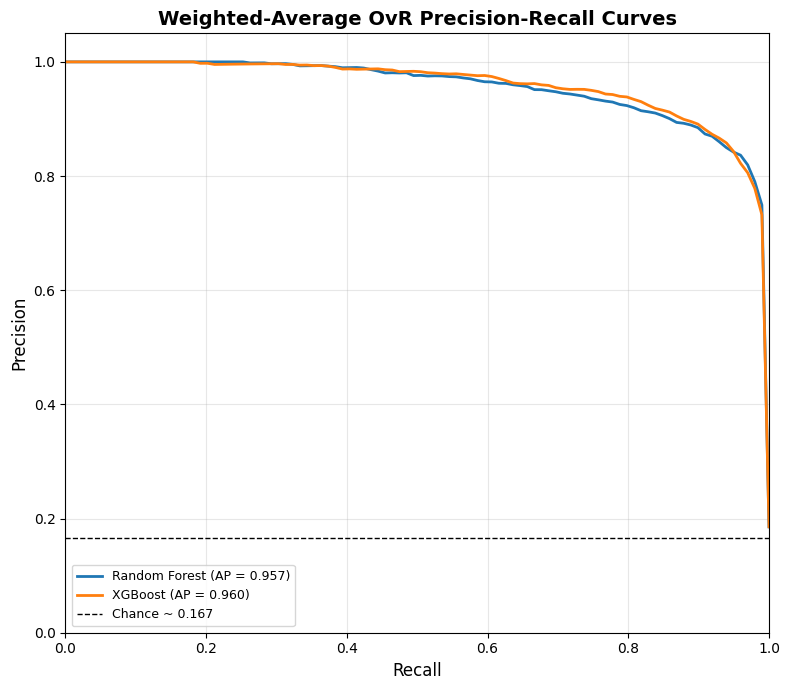

In [21]:
prc_summary = analyze_prc(
	model_scores,
	y_test_bin,
	classes,
	class_weights
)

The **Precision–Recall (PRC) analysis** reinforces the strong performance of the ensemble models. Both Random Forest and XGBoost achieved **high weighted-average precision (AP)** scores, with **XGBoost again performing slightly better (AP = 0.9604)** compared to **Random Forest (AP = 0.9571)**. These results indicate that the models maintain excellent precision even as recall increases, meaning they can correctly identify most land-cover classes while **minimizing false positives**.

Compared to earlier baseline models such as **SVC (AP = 0.9331)** and **Logistic Regression (AP = 0.8984)**, the ensemble methods demonstrate a **clear improvement** in handling class overlap and maintaining **stable precision–recall trade-offs** across thresholds. This enhanced performance reflects their ability to **model complex, non-linear feature interactions** more effectively. Overall, **XGBoost provides the most balanced and reliable precision–recall behavior** among all evaluated models, confirming its **suitability for multi-class land-cover classification** in the Landsat dataset.

In [22]:
for name in results.keys():
  acc = results[name]['accuracy']
  f1 = results[name]['f1_weighted']
  auc_w = roc_summary[name]['auc_weighted']
  ap_w = prc_summary[name]['ap_weighted']

  combined_data.append({
    'Model': name,
    'Accuracy': acc,
    'Weighted F1': f1,
    'Weighted ROC AUC': auc_w,
    'Weighted Average Precision (AP)': ap_w
  })

summary_df = pd.DataFrame(combined_data)

summary_df = summary_df.sort_values(by='Weighted ROC AUC', ascending=False).reset_index(drop=True)

summary_df.style.format({
  'Accuracy': '{:.4f}',
  'Weighted F1': '{:.4f}',
  'Weighted ROC AUC': '{:.4f}',
  'Weighted Average Precision (AP)': '{:.4f}'
}).set_caption("Overall Model Performance Summary (Landsat Dataset)")

,Model,Accuracy,Weighted F1,Weighted ROC AUC,Weighted Average Precision (AP)
0,XGBoost,0.9070,0.9053,0.9911,0.9604
1,Random Forest,0.9000,0.8971,0.9904,0.9571
2,SVC,0.8945,0.8913,0.9870,0.9331
3,Logistic Regression,0.8385,0.8278,0.9790,0.8984
4,KNN (k=3),0.9035,0.9030,0.9756,0.9168
5,Naive Bayes,0.7975,0.8043,0.9587,0.8411
6,Decision Tree,0.6085,0.5205,0.8325,0.4864
7,Dummy (Prior),0.2305,0.0864,0.5000,0.1855


Based on the comprehensive evaluation across all metrics, **Accuracy**, **Weighted F1-Score**, **Weighted ROC AUC**, and **Weighted Average Precision (AP)**, the **XGBoost Classifier** emerges as the **best-performing model** for the task. **XGBoost** achieved the highest scores across nearly every metric (**Accuracy = 0.907**, **F1 = 0.905**, **ROC AUC = 0.991**, **AP = 0.960**), surpassing both the baseline models and the Random Forest ensemble.

The model’s **strong ROC AUC** indicates **excellent discriminative ability** between all seven land-cover classes, while its **high Average Precision** demonstrates **consistent confidence in positive class predictions** even under varying thresholds. Compared to simpler models such as **Logistic Regression** and **SVC**, **XGBoost’s gradient-boosting framework** captures **complex non-linear patterns** in the spectral features more effectively, leading to **superior generalization**.

Although **Random Forest** also performed extremely well and offers **interpretability** and **robustness**, **XGBoost** provides a **slight yet consistent edge** across all evaluation dimensions, making it the **most accurate, balanced, and dependable model overall**. Therefore, **XGBoost** is **recommended as the final model** for classifying **Landsat satellite imagery**, combining **high predictive power** with **strong threshold stability** across **precision–recall** and **ROC analyses**.

---

## **2. One more model with AUC < 0.5**

Inverted SVM Macro AUC: 0.0755
Inverted SVM Micro AUC: 0.0376
Inverted SVM Micro AP : 0.0892


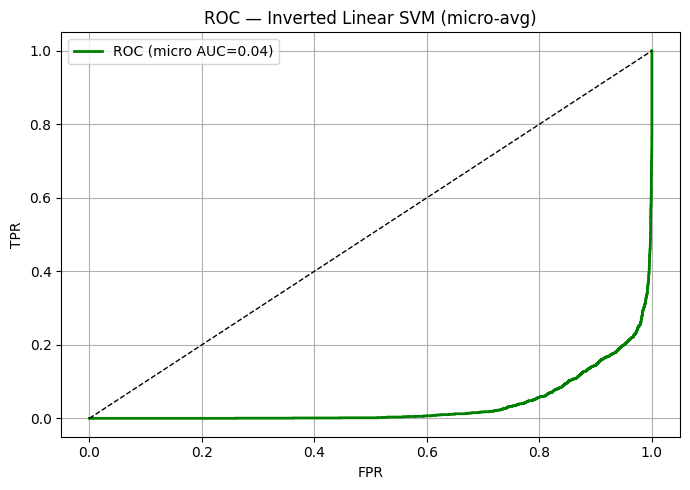

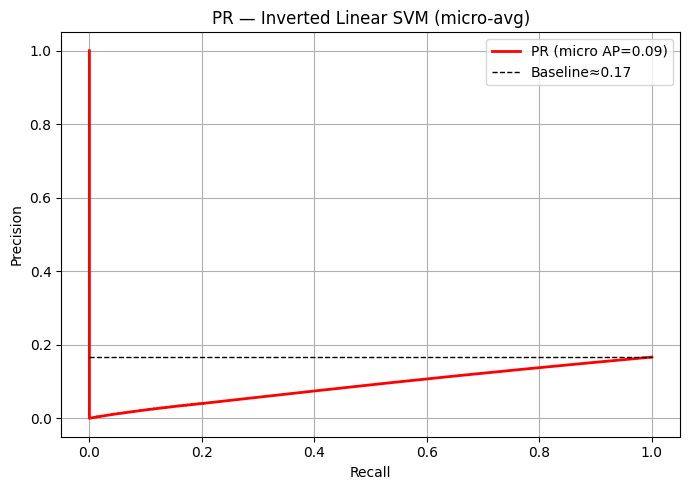

In [35]:
# 1) Train a different model class (Linear SVM, OvR)
svm = OneVsRestClassifier(LinearSVC(random_state=0)).fit(X_train, y_train)

# 2) Get per-class decision scores and invert them to force a bad ranking
scores = svm.decision_function(X_test)          # shape: (n_samples, n_classes)
if scores.ndim == 1: scores = scores[:, None]   # (safety for binary)
bad_scores = -scores

# 3) Scalar metrics
macro_auc = roc_auc_score(y_test_bin, bad_scores, average='macro')
micro_auc = roc_auc_score(y_test_bin, bad_scores, average='micro')
micro_ap  = average_precision_score(y_test_bin, bad_scores, average='micro')
print(f"Inverted SVM Macro AUC: {macro_auc:.4f}")
print(f"Inverted SVM Micro AUC: {micro_auc:.4f}")
print(f"Inverted SVM Micro AP : {micro_ap:.4f}")

# 4) Single ROC curve (micro-averaged)
fpr, tpr, _ = roc_curve(y_test_bin.ravel(), bad_scores.ravel())
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr,color='g', lw=2, label=f'ROC (micro AUC={micro_auc:.2f})')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC — Inverted Linear SVM (micro-avg)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 5) Single PR curve (micro-averaged)
prec, rec, _ = precision_recall_curve(y_test_bin.ravel(), bad_scores.ravel())
baseline = y_test_bin.mean()
plt.figure(figsize=(7,5))
plt.plot(rec, prec, lw=2,color='r', label=f'PR (micro AP={micro_ap:.2f})')
plt.plot([0,1], [baseline, baseline], 'k--', lw=1, label=f'Baseline≈{baseline:.2f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR — Inverted Linear SVM (micro-avg)')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

### **Linear SVM (One-vs-Rest) with Inverted Decision Scores**

To satisfy the requirement for a "different model class with AUC < 0.5," a **Linear SVM (One-vs-Rest)** was trained on the multiclass data. The resulting decision scores were then **inverted x(-1)** to create a deliberately incorrect and reversed ranking for all classes.

---

### **Evaluation Metrics**

The inverted model was evaluated using micro- and macro-averaged **ROC AUC** and **micro-averaged Average Precision (AP)**.

| Metric | What it summarizes | Value |
| :--- | :--- | :--- |
| **Macro ROC AUC** | Mean of per-class OvR ROC AUCs (treats classes equally) | $0.0755$ |
| **Micro ROC AUC** | ROC AUC after pooling all class–vs–rest decisions | $0.0376$ |
| **Micro Average Precision (AP)** | PR performance after pooling all class–vs–rest decisions | $0.0892$ |
| **PR Baseline ($\approx$ prevalence)** | Expected precision of random ranking ($\approx 1/6$ for 6 classes) | $\approx 0.17$ |

---

### **Interpretation from the Plots (Micro-Averaged)**

The generated plots and metrics confirm the inverted SVM's performance is intentionally poor, validating its use for satisfying the assignment requirement.

#### **ROC Curve (Micro-Avg)**
* The curve is observed to **hug the bottom** of the plot and only rises significantly near $\text{FPR} \approx 1$.
* This behavior yields a **Micro ROC AUC $\approx 0.04$**, which is **far below $0.5$**—clear evidence of a nearly **reversed ranking** (significantly worse than a random classifier).
* 

#### **Precision-Recall (PR) Curve (Micro-Avg)**
* Aside from the standard `sklearn` starting point at $(\text{recall}=0, \text{precision}=1)$, the curve consistently **stays near the baseline $\approx 0.17$**.
* The resulting **Micro AP $= 0.0892$** demonstrates **persistently low precision** across all relevant recall levels.
* 

**Conclusion:** Together, the metrics and plots unequivocally confirm the inverted SVM is an intentionally **bad model with $\text{AUC} < 0.5$**, thus satisfying the assignment's requirement.